# cumcm-a

## 准备阶段

### 数据读取

In [32]:
# 测试地方

from sympy import *
a = Symbol('a')
b = Symbol('b')
c = Symbol('c')
# m = Matrix([0, 0, 0])
m = Matrix([a, b, c])
# m = MatrixSymbol('m', 3, 1)
d = Matrix([2, 4, 6])
# l = Symbol('l')
# solve([m * l - a], [l, ])
# solve([Matrix([a, b, c]) * 2 - d, ], [a, b, c, ])
solve([m * 2 - d, ], [a, b, c, ])
# solve([m * 2 - d], [m, ])

[]

In [3]:
import numpy as np
import pandas as pd

# 主索节点的坐标和编号
data1 = pd.read_csv("data/附件1.csv", encoding='ANSI')
# print('主索节点的坐标和编号:\n', data1)
nodes_data = {}
for d in data1.itertuples():
    nodes_data[d[1]] = {
        # 'position': tuple(d[2:]),
        'position_raw': np.array(d[2:]),
        'position': np.array(d[2:]),
        # 伸缩量，即所有需要求解的变量
        'expand': 0
    }

# 促动器下端点（地锚点）坐标、
# 基准态时上端点（顶端）的坐标，
# 以及促动器对应的主索节点编号
data2 = pd.read_csv("data/附件2.csv", encoding='ANSI')
# print('data2:\n', data2)
for d in data2.itertuples():
    nodes_data[d[1]]['actuactor_head'] = np.array(d[2:5])
    nodes_data[d[1]]['actuactor_base'] = np.array(d[5:8])

# print(nodes_data)

triangles_data = []

# 反射面板对应的主索节点编号
data3 = pd.read_csv("data/附件3.csv", encoding='ANSI')
# print('data3:\n', data3)
for d in data3.itertuples():
    triangles_data.append(tuple(d[1:]))

# print(triangles_data)


### 测试绘图

绘制点的函数

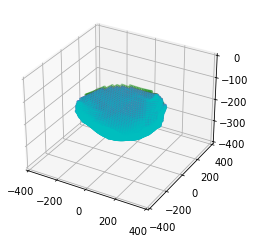

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *


# 绘制当前图像
def draw_points(points: np.ndarray = None, nodes_data_: dict = nodes_data):
    if points is None:
        points = to_points(nodes_data_=nodes_data_)
    ax = plt.axes(projection='3d')
    plt.xlim(-400, 400)
    plt.ylim(-400, 400)
    ax.set_zlim(-400, 0)
    ax.scatter3D(points.T[0], points.T[1], points.T[2], c="g", marker='.')
    points2 = to_points(nodes_data_=nodes_data_, dict_key='actuactor_head')
    ax.scatter3D(points2.T[0], points2.T[1], points2.T[2], c="c", marker='.')
    points3 = to_points(nodes_data_=nodes_data_, dict_key='actuactor_base')
    ax.scatter3D(points3.T[0], points3.T[1], points3.T[2], c='m', marker='.')
    plt.show()


# 拿到单位方向向量(pt1 -> pt2)
def get_unit_vector(pt1: np.ndarray, pt2: np.ndarray) -> np.ndarray:
    a = pt2 - pt1
    n = a / np.sqrt(a[0] ** 2 + a[1] ** 2 + a[2] ** 2)
    return n


# 计算在当前伸缩值状态下，主索节点的位置(position)
def update_expand(nodes_data_: dict = nodes_data):
    for name in nodes_data_:
        node = nodes_data_[name]
        # 用促动器下端坐标和最初的主索节点位置确定方向向量，计算伸缩量
        n = get_unit_vector(node['position_raw'], node['actuactor_base'])
        # 更新 position
        node['position'] = node['position_raw'] + n * node['expand']


# 三个点确定一个平面
def triangle_to_plane(triangle: tuple) -> np.ndarray:
    points = [nodes_data[code]['position'] for code in triangle]
    # Ax + By + Cz + D = 0
    A = (points[2][1] - points[0][1]) * (points[2][2] - points[0][2]) - \
        (points[1][2] - points[0][2]) * (points[2][1] - points[0][1])
    B = (points[2][0] - points[0][0]) * (points[1][2] - points[0][2]) - \
        (points[1][0] - points[0][0]) * (points[2][2] - points[0][2])
    C = (points[1][0] - points[0][0]) * (points[2][1] - points[0][1]) - \
        (points[2][0] - points[0][0]) * (points[1][1] - points[0][1])
    D = -(A * points[0][0] + B * points[0][1] + C * points[0][2])
    return np.array((A, B, C, D))


# 求点到平面的对称点
def plane_symmetry_point(plane: np.ndarray, point: np.ndarray) -> np.ndarray:
    A, B, C, D = plane
    # x1, y1, z1 = point
    x2, y2, z2 = Symbol('x2'), Symbol('y2'), Symbol('z2')
    # ((x1 + x2) / 2, (y1 + y2) / 2, (z1 + z2) / 2)
    # (x1 + x2) / 2 * A + (y1 + y2) / 2 * B + (z1 + z2) / 2 * C + D = 0
    # (x1 + x2) * A + (y1 + y2) * B + (z1 + z2) * C + 2 * D = 0
    # (p - point) == l * (A, B, C)
    l = Symbol('l')
    print(Matrix(point).shape)
    print(Matrix([x2, y2, z2]).shape)
    print(Matrix([A, B, C]).shape)
    result = solve([Matrix(point) - Matrix([x2, y2, z2]) - l * Matrix([A, B, C]), 
                    np.dot(np.array(point) + np.array([x2, y2, z2]), np.array([A, B, C])) + 2 * D], [x2, y2, z2, l])
    # print(result, type(result))
    return np.array([result[x2], result[y2], result[z2]])


# 转换数据到坐标
def to_points(nodes_data_: dict = nodes_data, dict_key: str = 'position') -> np.ndarray:
    points = []
    for name in nodes_data_:
        node = nodes_data_[name]
        points.append(node[dict_key])
    return np.array(points)


draw_points()
# print(plane_symmetry_point([1, 1, 1, 0], [2, 2, 2]))
